One technique/tool for address unbalanced data is SMOTE.  I've added the original SMOTE paper to the module page (thanks to Esther for digging it out).  I've also linked to the libraries associated with this (contains a whole suite of techniques for unbalanced data).

https://moodle.city.ac.uk/pluginfile.php/2571477/mod_resource/content/1/SMOTE.pdf

https://imbalanced-learn.org/stable/references/index.html



**Plan**: we need to understand correlations:
- **1** 'Severity of Illness' at 'Type of Admission' on 'Stay', those with higher - longer
- **2** if high, then less 'Visitors with Patient'  but long 'Stay'
- **3** prior knowledge of LOS can aid in logistics such as room and bed allocation planning= all high risk together

## Content:
- [Part 1](#part1)- Importing the data set
- [Part 2](#part2)- Exploratory data analysis
- [Part 3](#part3) -  Preparing our data
- [Part 4](#part4) -  Correlation
- [Part 5](#part5) -  Splitting our data for modelling
- [Part 6](#part6) -  Decision tree model (reservation_status included)
- [Part 7](#part7) -  Decision tree model (reservation_status excluded)
- [Part 8](#part8) -  K-nearest neighbours
- [Part 9](#part9) -  Naïve Bayes
- [Part 10](#part10) -  Conclusion
    
P.S. The length of stay - 11 different classes ranging from 0-10 days to more than 100 days.

**Here's a description of what some of the features in the dataframe above represent:**

- `Column`	Description
- `case_id`	Case_ID registered in Hospital
- `Hospital_code`	Unique code for the Hospital
- `Hospital_type_code`	Unique code for the type of Hospital
- `City_Code_Hospital` City Code of the Hospital
- `Hospital_region_code`	Region Code of the Hospital
- `Available Extra Rooms in Hospital`	Number of Extra rooms available in the Hospital
- `Department`	Department overlooking the case
- `Ward_Type`	Code for the Ward type
- `Ward_Facility_Code`	Code for the Ward Facility
- `Bed Grade`	Condition of Bed in the Ward
- `patientid`	Unique Patient Id
- `City_Code_Patient`	City Code for the patient
- `Type of Admission`	Admission Type registered by the Hospital
- `Severity of Illness`	Severity of the illness recorded at the time of admission
- `Visitors with Patient`	Number of Visitors with the patient
- `Age`	Age of the patient
- `Admission_Deposit`	Deposit at the Admission Time
- `Stay`	Stay Days by the patient


[Back to top](#Content:)


<a id='part1'></a>

### Part 1 -  Importing the data set

In [1]:
import os
# import sys
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
%matplotlib inline

# import tensorflow as tf
# from tensorflow import keras


In [2]:
path = "healthcare"

filename_read = os.path.join(path, "train_data.csv")
df = pd.read_csv(filename_read, na_values=['NA', '?'])

# print(df[0:5])
print(df.shape)
print(df.columns)

(318438, 18)
Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')


In [3]:
## loading the file
health_care = pd.read_csv('./healthcare/train_data.csv')

In [4]:
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449.0,11-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167.0,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571.0,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056.0,31-40


[Back to top](#Content:)

<a id='part2'></a>
### Part 2- Exploratory data analysis (EDA)

In [4]:
#creating a copy of df to have an original for further manipulation
new_df = df.copy()
new_df = new_df.select_dtypes(include=["int","float"])

headers = list(new_df.columns.values)

## For this part you should drop  :
- Case_id
- Hospital_code
- patientid
- City_Code_Patient

There mean/std is not relevant

In [5]:
fields = []
for field in headers:
    fields.append({
        "name":field,
        "mean":df[field].mean(),
        "var":df[field].var(),
        "sdev":df[field].std()
    })
for field in fields:
    print(field)

{'name': 'case_id', 'mean': 159219.5, 'var': 8450256523.484579, 'sdev': 91925.27684747313}
{'name': 'Hospital_code', 'mean': 18.318840716246175, 'var': 74.54172342795314, 'sdev': 8.633754885792921}
{'name': 'City_Code_Hospital', 'mean': 4.771716943329627, 'var': 9.62572562697152, 'sdev': 3.102535354669068}
{'name': 'Available Extra Rooms in Hospital', 'mean': 3.1976271676119055, 'var': 1.364624484865746, 'sdev': 1.1681714278588335}
{'name': 'Bed Grade', 'mean': 2.625806958297338, 'var': 0.7623835960741749, 'sdev': 0.873145804590605}
{'name': 'patientid', 'mean': 65747.57947229916, 'var': 1442475571.9882374, 'sdev': 37979.93644002367}
{'name': 'City_Code_Patient', 'mean': 7.251858836721821, 'var': 22.517545245763493, 'sdev': 4.745265561142337}
{'name': 'Visitors with Patient', 'mean': 3.2840992595104854, 'var': 3.1119125861261314, 'sdev': 1.7640613895571013}
{'name': 'Admission_Deposit', 'mean': 4880.749392346391, 'var': 1181082.625479292, 'sdev': 1086.7762536416094}


#????**here should an analysis of columns means and st dev**

Missing Values

In [5]:
#checking for missing values
df.isnull().values.any()

True

In [6]:
#Checking number of NANs for each column, in order to understand how many missing values there are in a dataframe.
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


## NA values :

Represent 1.45% for the data set, i think either drop it or check later if City_Code_Patient is actually a relevant covariant, if not drop it and keep the rest of data

## Feature engineering

We will add 2 features : 
- Visit number
- New Patient

In [62]:
n = health_care.shape[0]
visits = []
patientid = np.array(health_care['patientid'])
for i in range(n) :
    count = (patientid[:i+1] == patientid[i]).sum()
    visits.append(count)
    
health_care['Visit Number'] = visits
health_care['New Patient'] = (health_care['Visit Number']==1).astype('int32')

To make sure we consider all the correct features to make an accurate prediction, it may be useful to create some plots to have a better understanding of our data.

we will be using the Python data visualisation library seaborn. 

We could begin by visualising the length of stays by type of admissions etc., by using a countplot(), that shows the counts of observations in each categorical bin using bars.

In [9]:
#sorting by Stay for better representation in the visualisations
df= df.sort_values(by = "Stay", ascending = True)
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
136814,136815,28,b,11,X,2,gynecology,R,F,3.0,112307,1.0,Emergency,Moderate,2,21-30,4517.0,0-10
136815,136816,29,a,4,X,3,gynecology,S,F,3.0,112307,1.0,Emergency,Moderate,2,21-30,3846.0,0-10
136823,136824,11,b,2,Y,4,gynecology,Q,D,4.0,64198,14.0,Emergency,Moderate,2,21-30,5183.0,0-10
136837,136838,14,a,1,X,3,gynecology,R,E,3.0,76865,1.0,Emergency,Extreme,3,51-60,3452.0,0-10
136845,136846,1,d,10,Y,3,radiotherapy,S,B,4.0,19181,7.0,Emergency,Minor,2,51-60,3908.0,0-10
136846,136847,1,d,10,Y,2,radiotherapy,S,B,4.0,19181,7.0,Emergency,Minor,2,51-60,3934.0,0-10
136847,136848,12,a,9,Y,5,gynecology,Q,B,1.0,19181,7.0,Urgent,Moderate,4,51-60,3410.0,0-10
136866,136867,14,a,1,X,2,gynecology,R,E,3.0,101538,8.0,Emergency,Moderate,3,51-60,4222.0,0-10
136874,136875,6,a,6,X,2,gynecology,Q,F,3.0,40220,8.0,Emergency,Moderate,4,71-80,5746.0,0-10


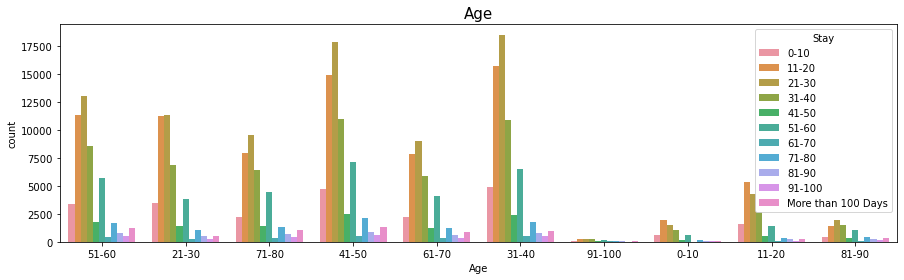

In [10]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Age", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Age", hue = 'Stay', data = df)

In [11]:
#?? comments
#the age group risk - 21-80y.o.

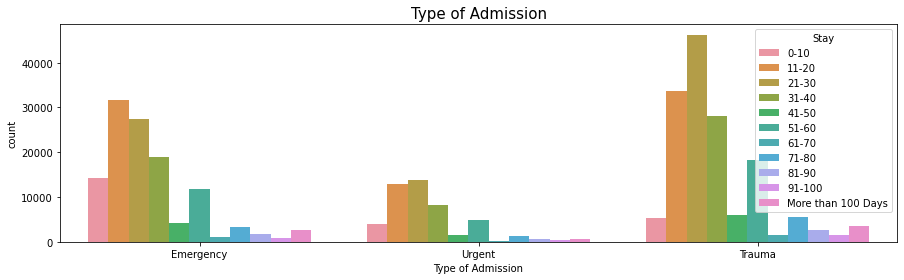

In [12]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Type of Admission", fontdict = {'fontsize': 15})
ax = sns.countplot(x = "Type of Admission", hue = 'Stay', data = df)


???? comments on the graph


Emergency and Trauma and mostly from 11 - 40  and range 51-60 


Next, it may be interesting to look at the Severity of Illness segments by stay.

Again, we can use a count plot to visualise this.

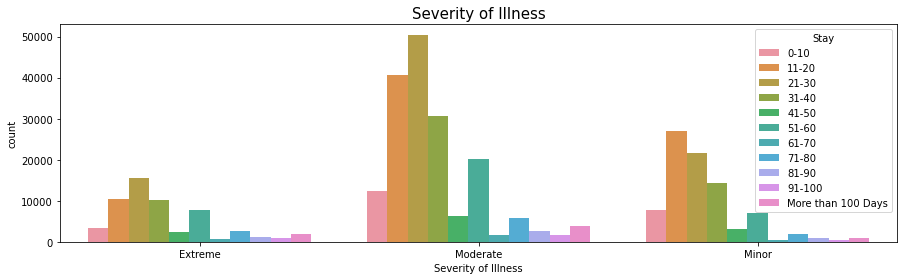

In [13]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Severity of Illness", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Severity of Illness", hue = 'Stay', data = df)

???? comments on the graph: 


mostly moderate and minor, and in age range 11-40  and range 51-60 


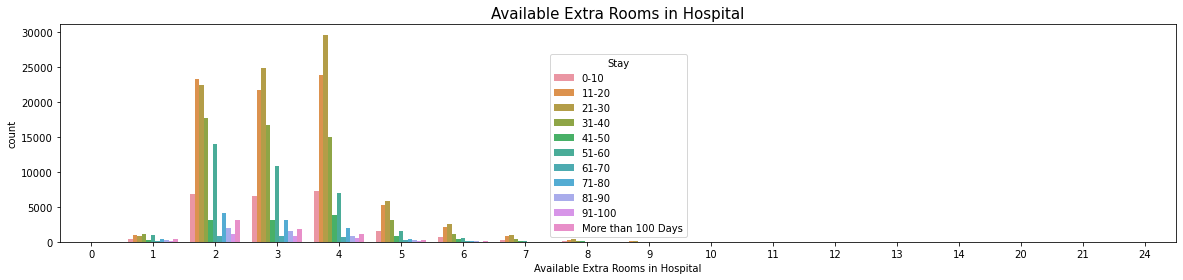

In [14]:
#plot size
plt.figure(figsize = (20,4))
#plot title
plt.title("Available Extra Rooms in Hospital", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Available Extra Rooms in Hospital", hue = 'Stay', data = df)

???? comments on the graph

most rooms have additional 2-4 beds in the room available.

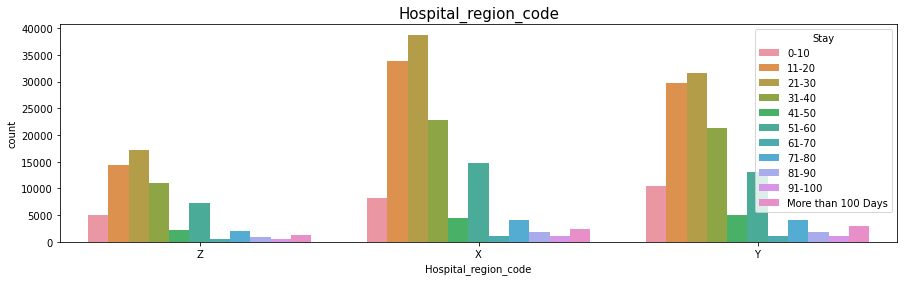

In [14]:
#plot size
plt.figure(figsize = (15,4))
#plot title
plt.title("Hospital_region_code", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Hospital_region_code", hue = 'Stay', data = df)

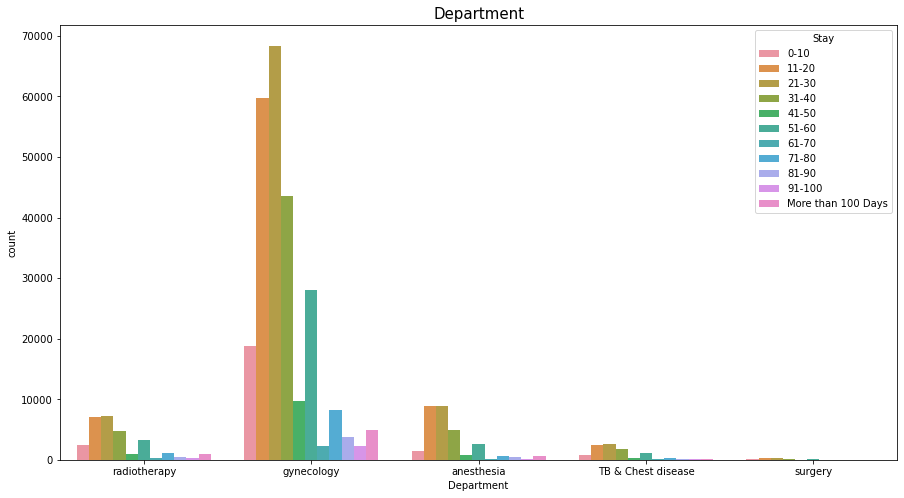

In [15]:
#plot size
plt.figure(figsize = (15,8))
#plot title
plt.title("Department", fontdict = {'fontsize':15})
ax = sns.countplot(x = "Department", hue = 'Stay', data = df)

In [16]:
#??? commments
#mostly gynecology department

# Data Analysis Part - Baraa

In [5]:
## Checking target
target = health_care['Stay']

In [6]:
## Encoding data
encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

### Checkin for number of unique element for each feature

In [7]:
for column in health_care.columns :
    x = pd.unique(health_care[column])
    print(f'number of unique elements of  {column} is : {len(x)}')

number of unique elements of  case_id is : 318438
number of unique elements of  Hospital_code is : 32
number of unique elements of  Hospital_type_code is : 7
number of unique elements of  City_Code_Hospital is : 11
number of unique elements of  Hospital_region_code is : 3
number of unique elements of  Available Extra Rooms in Hospital is : 18
number of unique elements of  Department is : 5
number of unique elements of  Ward_Type is : 6
number of unique elements of  Ward_Facility_Code is : 6
number of unique elements of  Bed Grade is : 5
number of unique elements of  patientid is : 92017
number of unique elements of  City_Code_Patient is : 38
number of unique elements of  Type of Admission is : 3
number of unique elements of  Severity of Illness is : 3
number of unique elements of  Visitors with Patient is : 28
number of unique elements of  Age is : 10
number of unique elements of  Admission_Deposit is : 7300
number of unique elements of  Stay is : 11


## Visualisation of Target categories

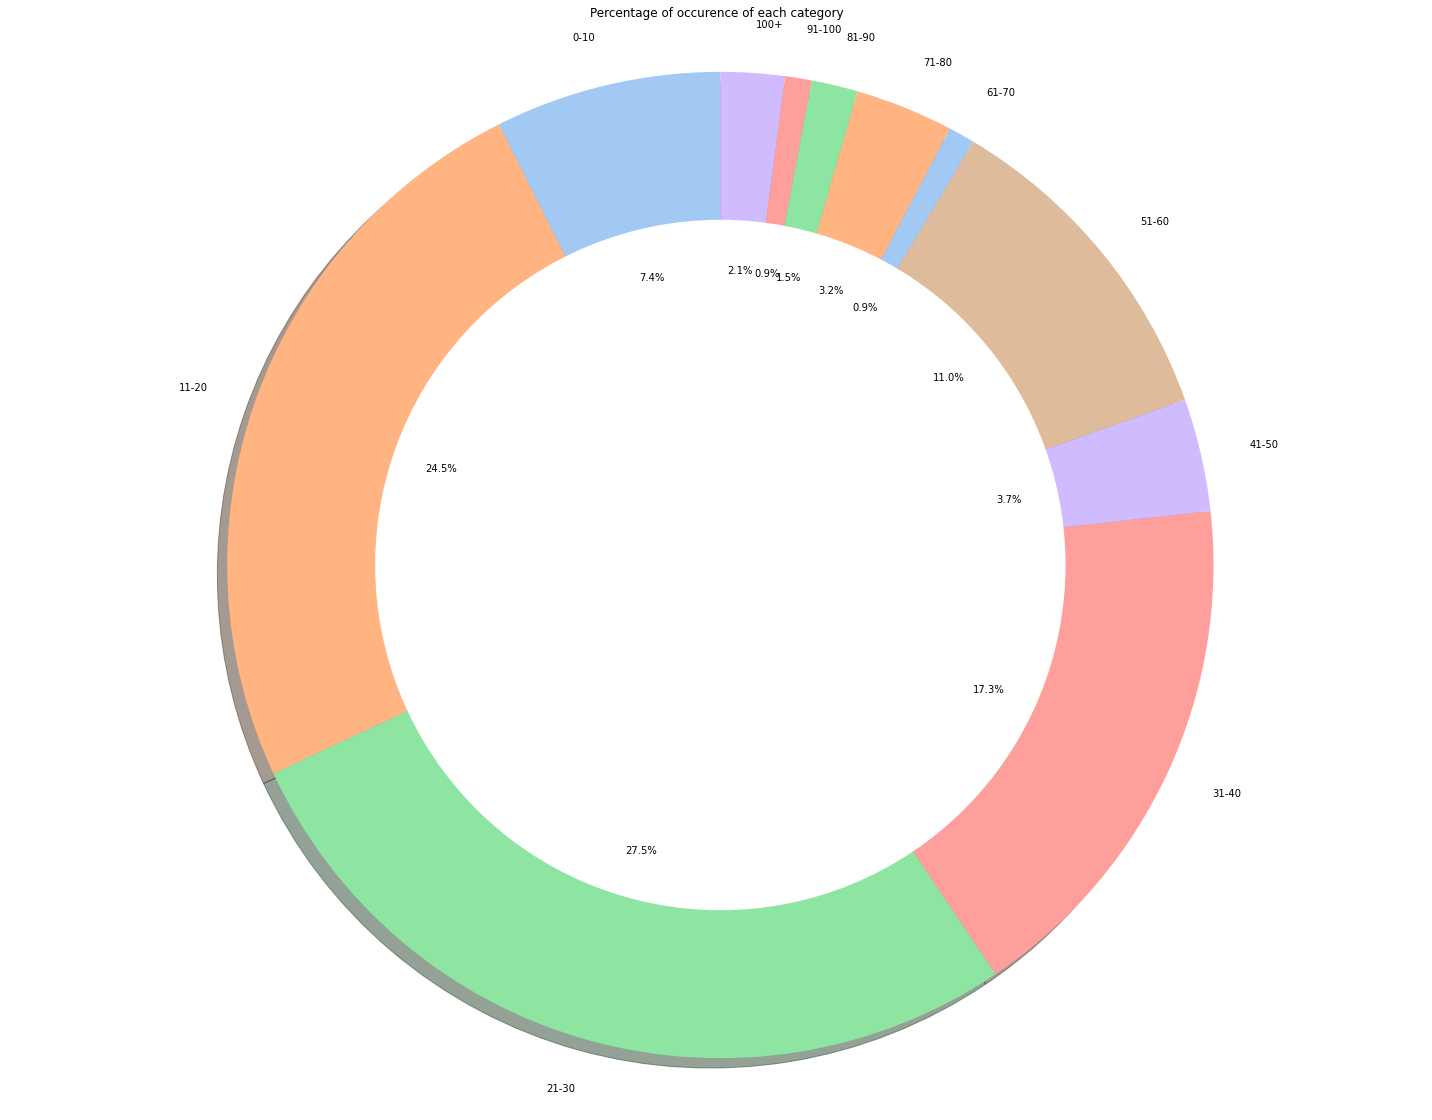

In [8]:
fig, ax1 = plt.subplots()
labels = np.unique(health_care['Stay'])
labels[-1] = '100+'

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:6]
plt.pie(health_care.groupby('Stay').size(), labels = labels,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.set_size_inches(20, 15.5)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Percentage of occurence of each category')
plt.show()

## Remark

Data shows an unusual distribution of the length of stay categories, especially we see that the 51-60 category is abnormally higher than what we could expect.

McClean and Millard (1993) have established that lognormal and exponential mixture distributions might be a better description for the LOS dataset. Marazzi et al. (1998) established to check the adequacy of lognormal (long tailed), Weibull and gammamodels (short tailed) to study LOS and concluded that Weibull and gamma behaved similarly in nature. Clark and Ryan (2002) and Clark et al. (2007) considered piecewise exponential models for predicting mortality, hospital LOS, and long-term care for trauma patients. Gardiner (2014) considered Coxian phase-type models, mixtures of exponential distributions, and other heavy-tailed distributions such as Weibull, Pareto, generalized Pareto, lognormal for modeling LOS by parametric and Bayesian approaches. The modeling of LOS with the help of convolutive mixture distribution for studying the short and long stay of patients in the hospital is studied by Ickowicz and Sparks (2016).

## Histogram plot 


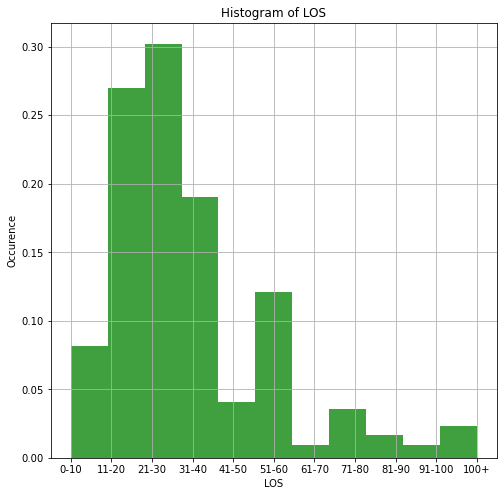

In [36]:
h = health_care['Stay'].sort_values()
h[h=='More than 100 Days'] = '100+'
plt.figure(figsize = (8,8))
plt.hist(h, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)



plt.xlabel('LOS')
plt.ylabel('Occurence')
plt.title('Histogram of LOS')


plt.grid(True)
plt.show()

The percentage of patient staying more than 60 days is 8.55%

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
health_care['Stay_cat'] = encoder.fit_transform(health_care['Stay'])
n = len(health_care['Stay_cat'])
l = []
for i in range(len(np.unique(health_care['Stay_cat']))):
    k = len(health_care[health_care['Stay_cat']==i])
    #print(f'N {10*i} and {10*(i+1)} is : {k}')
    print(f'{i}- {k}  : {100*k/n:.2f}%')
   
    
    
    
    

0- 23604  : 7.41%
1- 78139  : 24.54%
2- 87491  : 27.48%
3- 55159  : 17.32%
4- 11743  : 3.69%
5- 35018  : 11.00%
6- 2744  : 0.86%
7- 10254  : 3.22%
8- 4838  : 1.52%
9- 2765  : 0.87%
10- 6683  : 2.10%


In [18]:
## functions to feed to barplot
def mean(x):
    return np.mean(x)

def median(x):
    return np.median(x)

def std(x):
    return np.std(x)


In [19]:
## Estimate of length of stay
target_estimate = 10* (target_enc) + 5
# Adding the estimate to the dataframe
health_care['Stay Estimate'] = target_estimate


In [20]:
## Using only Features with limited classes for the plot
elements_to_remove = ['case_id', 'patientid', 'Admission_Deposit', 'Stay', 'Stay Estimate']
column_features = [ column for column in health_care.columns if column not in elements_to_remove]
print(column_features)

['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age']


## Mean Analysis

We study the relationship between the mean of stay and each feature

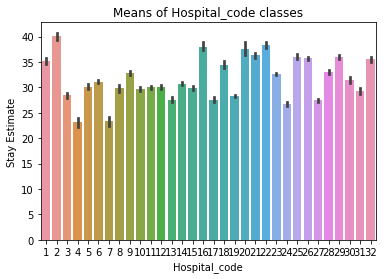

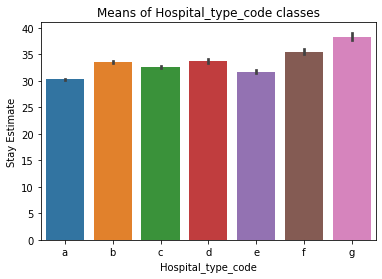

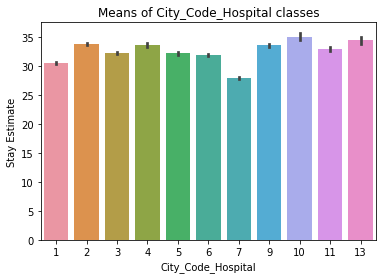

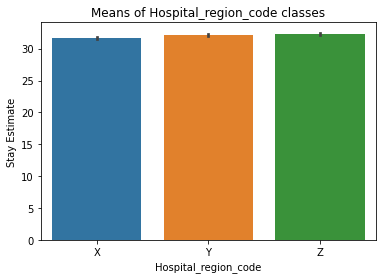

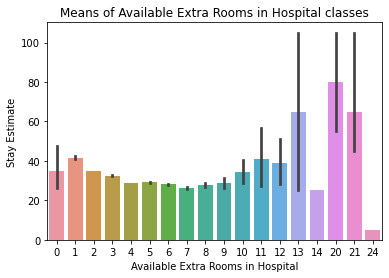

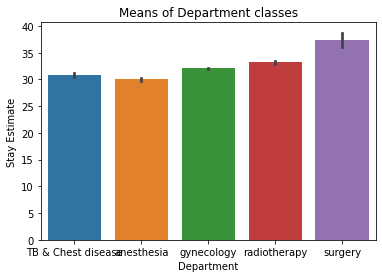

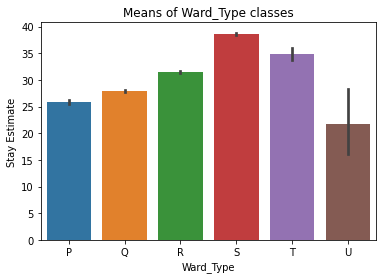

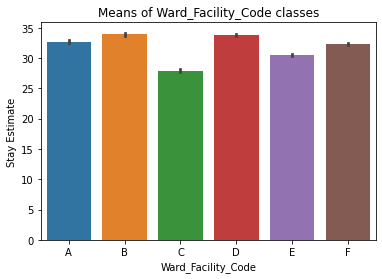

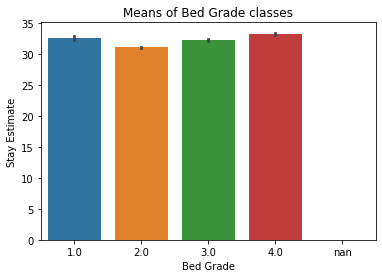

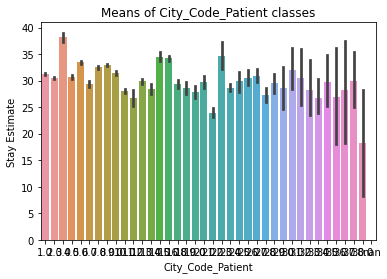

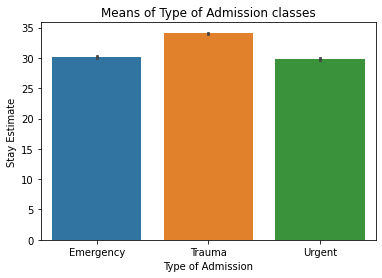

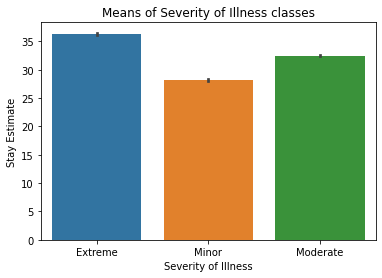

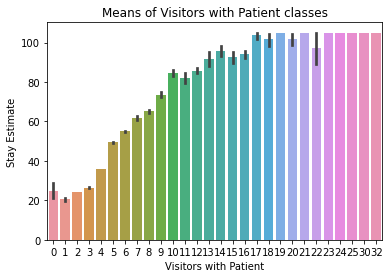

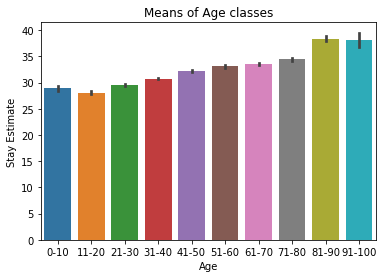

In [21]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=mean)
    ax.set_title(f'Means of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the mean of the stay : 
- Hospital_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Type Of Admission
- Severity of Illness
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

The 2 features that seem to have a good prediction power from the plot are :
- Visitor with Patient
- Age

**Remark** : Data source doesn't specify if the visitor with patient is correlated to the time of stay ? 

## Median Analysis


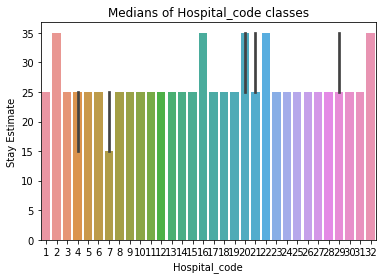

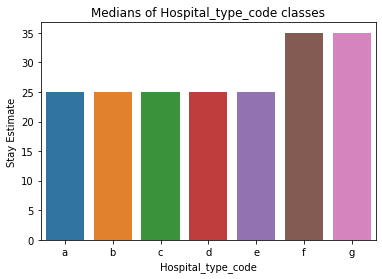

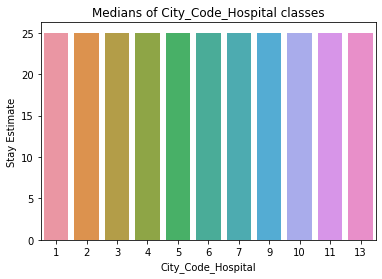

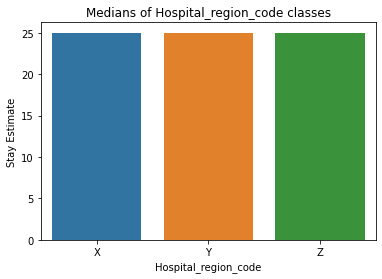

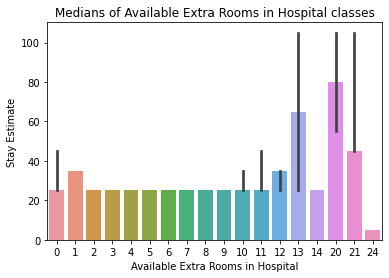

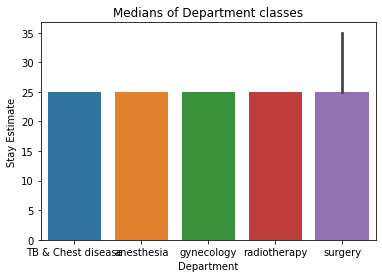

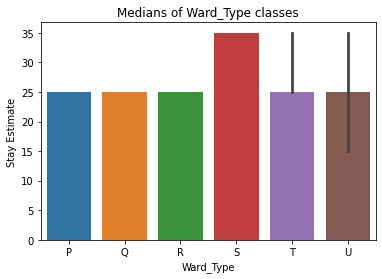

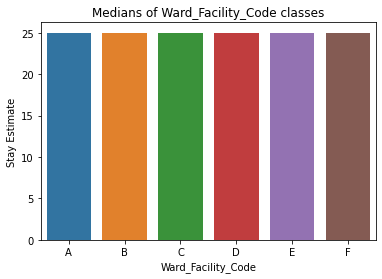

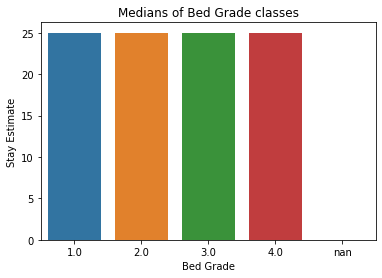

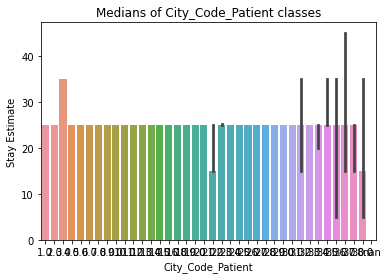

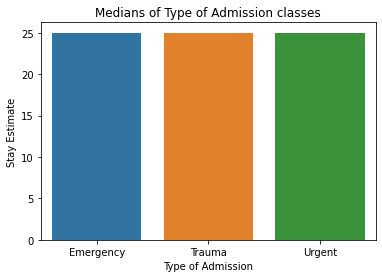

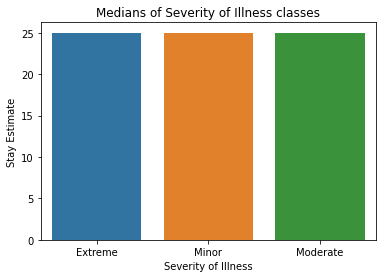

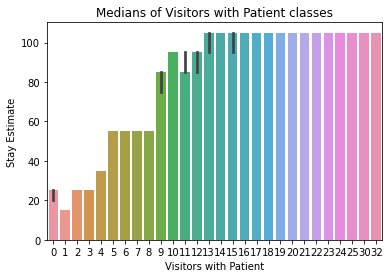

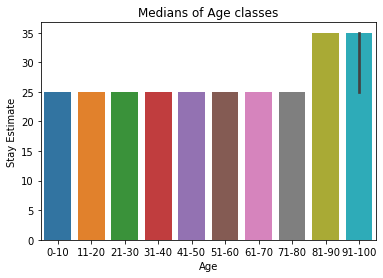

In [22]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=median)
    ax.set_title(f'Medians of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the median of the stay : 
- Hospital_code
- Hospital_type_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

## Analysis of Std

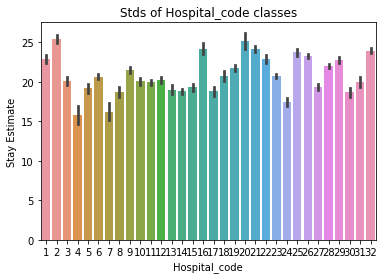

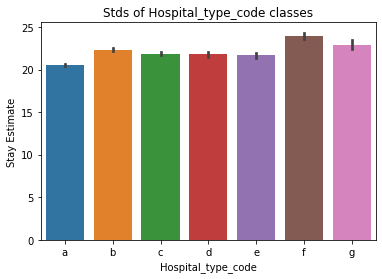

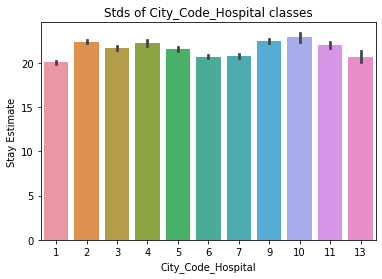

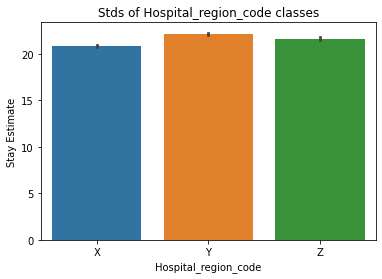

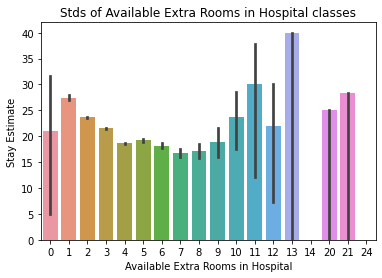

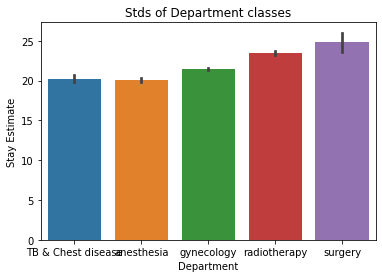

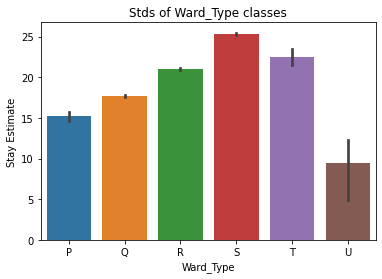

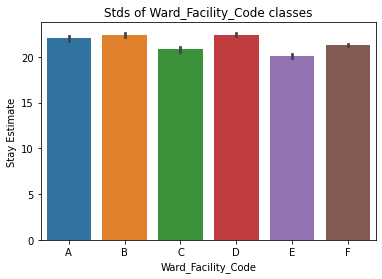

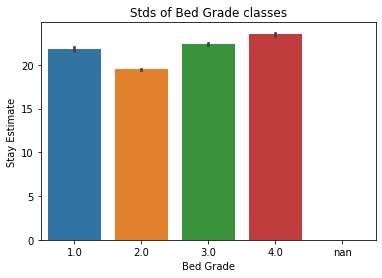

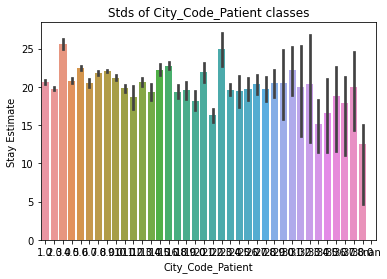

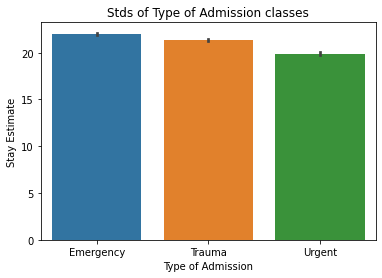

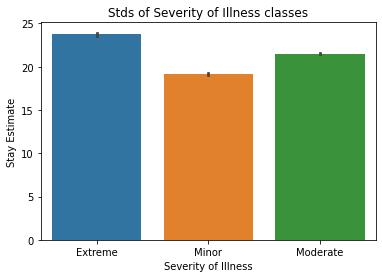

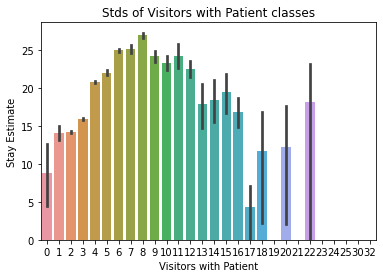

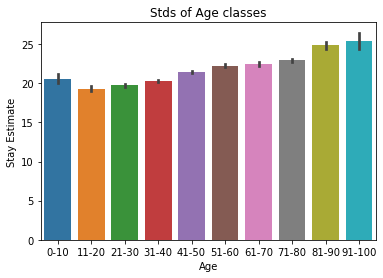

In [23]:
for feature in column_features :
    order = pd.unique(health_care[feature])
    order.sort()
    ax = sns.barplot(x=feature, y="Stay Estimate", data=health_care,order=order, estimator=std)
    ax.set_title(f'Stds of {feature} classes') 
    plt.show();
    
    
    
    

## Conclusion :

Feature that appear to have some influence on the median of the stay : 
- Hospital_code
- Available Extra Room : To verifiy if the amount of available data is conclusive 
- Ward_Type
- City_Code_Patient
- Severity of Illness
- Type Of Admission
- Visitors with Patient : To verify since maybe it's correlated to the length of stay
- Age

[Back to top](#Content:)

<a id='part3'></a>
### Part 3 - Preparing our data

We saw in Part 2 that columns **"Bed Grade"** and **"City_Code_patient"** have missing values. Before deciding whether we shall drop these columns or keep some of them and try to fill the missing values with medians, we can make and analysis to understand the percentage of missing values by creating this function **"perc_mv"**.


In [17]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

In [18]:
print('Missing value ratios:\nBed Grade: {}\nCity_Code_Patient: {}'.format(
    perc_mv(df, df['Bed Grade']),
    perc_mv(df, df['City_Code_Patient'])))

Missing value ratios:
Bed Grade: 0.035485714644609
City_Code_Patient: 1.4231969802598936


**As we can see, 0.03% of Bed Grade column and 1.42% of City_Code_Patient has missing values. Therefore, we have enough values to fill the rows of the company column via any imputation method.**

In [25]:
# Assuming importance of the City_Code_Patient in the future analysis is minimalistic
# let s drop it 

df = df.drop(['City_Code_Patient'], axis = 1)

In [26]:
#let's fill missing values of 'Bed Grade' with its median of the column
med = df['Bed Grade'].median()
df['Bed Grade'] = df['Bed Grade'].fillna(med)

In [27]:
#missing values check after data manipulation
df.isnull().values.any()

False

Next, we may want to check the features to create some more meaningful variables and reduce the number of features.


In [28]:
#????think of smth to work on the type
#In the code cell below, we use the attribute dtype on df to retrieve the data type for each column.
print (df.dtypes)

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object


In [29]:
#We want to map the name of each Severity of Illness to the corresponding number in ascending order.
df['Severity of Illness'] = df['Severity of Illness'].map({'Minor':1, 'Moderate': 2, 'Extreme':3})
df['Type of Admission'] = df['Type of Admission'].map({'Trauma':1, 'Emergency': 2, 'Urgent':3})
df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,2,3,2,51-60,4911.0,0-10
136814,136815,28,b,11,X,2,gynecology,R,F,3.0,112307,2,2,2,21-30,4517.0,0-10
136815,136816,29,a,4,X,3,gynecology,S,F,3.0,112307,2,2,2,21-30,3846.0,0-10
136823,136824,11,b,2,Y,4,gynecology,Q,D,4.0,64198,2,2,2,21-30,5183.0,0-10
136837,136838,14,a,1,X,3,gynecology,R,E,3.0,76865,2,3,3,51-60,3452.0,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68359,68360,10,e,1,X,2,gynecology,S,E,3.0,113737,1,2,6,61-70,4345.0,More than 100 Days
15335,15336,18,d,13,Y,2,gynecology,R,B,3.0,17210,1,2,8,71-80,4413.0,More than 100 Days
15334,15335,18,d,13,Y,2,gynecology,R,B,3.0,17210,1,2,8,71-80,3080.0,More than 100 Days
31499,31500,26,b,2,Y,2,gynecology,Q,D,3.0,79939,1,2,20,51-60,5087.0,More than 100 Days


For now, we assume these columns are not important for our analysis:

0case_id

1Hospital_code 

2Hospital_type_code

3City_Code_Hospital  

7Ward_Type - anyways we know department, so we can guess the ward type

8Ward_Facility_Code

In [24]:
#dropping unwanted columns
df.drop(df.columns[0:4],axis=1, inplace=True)
df.drop(df.columns[3:5], axis=1, inplace=True)
print(df.shape)
df

(318438, 11)


,Hospital_region_code,Available Extra Rooms in Hospital,Department,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,Z,3,radiotherapy,2.0,31397,2,3,2,51-60,4911.0,0-10
136814,X,2,gynecology,3.0,112307,2,2,2,21-30,4517.0,0-10
136815,X,3,gynecology,3.0,112307,2,2,2,21-30,3846.0,0-10
136823,Y,4,gynecology,4.0,64198,2,2,2,21-30,5183.0,0-10
136837,X,3,gynecology,3.0,76865,2,3,3,51-60,3452.0,0-10
...,...,...,...,...,...,...,...,...,...,...,...
68359,X,2,gynecology,3.0,113737,1,2,6,61-70,4345.0,More than 100 Days
15335,Y,2,gynecology,3.0,17210,1,2,8,71-80,4413.0,More than 100 Days
15334,Y,2,gynecology,3.0,17210,1,2,8,71-80,3080.0,More than 100 Days
31499,Y,2,gynecology,3.0,79939,1,2,20,51-60,5087.0,More than 100 Days


In [34]:
#using LabelEncoder to change and transform the object format of 
#'Hospital_region_code','Department','Age', 'Stay' columns
le = LabelEncoder()
for col in ['Hospital_region_code','Department','Age', 'Stay']:
    df[col]= df[col].astype('str')
    df[col]= le.fit_transform(df[col])
print (df.dtypes)

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                   int64
Available Extra Rooms in Hospital      int64
Department                             int64
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
Type of Admission                      int64
Severity of Illness                    int64
Visitors with Patient                  int64
Age                                    int64
Admission_Deposit                    float64
Stay                                   int64
dtype: object


In [26]:
#shuffling
df= df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

[Back to top](#Content:)

<a id='part4'></a>
### Part 4 - Correlation

In [27]:
#creating a copy of df to have an original for further manipulation
cor_df = df.copy()

In [30]:
#creating a copy of df to have an original for further manipulation
corr = health_care.copy()

In [32]:
#We want to map the name of each Severity of Illness to the corresponding number in ascending order.
corr['Severity of Illness'] = corr['Severity of Illness'].map({'Minor':1, 'Moderate': 2, 'Extreme':3})
corr['Type of Admission'] = corr['Type of Admission'].map({'Trauma':1, 'Emergency': 2, 'Urgent':3})


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,...,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Stay Estimate,Visit Number,New Patient
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,...,7.0,2,3,2,51-60,4911.0,0-10,5,1,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,...,7.0,1,3,2,51-60,5954.0,41-50,45,2,0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,...,7.0,1,3,2,51-60,4745.0,31-40,35,3,0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,...,7.0,1,3,2,51-60,7272.0,41-50,45,4,0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,...,7.0,1,3,2,51-60,5558.0,41-50,45,5,0


In [36]:
corr['Age Estimate'] = le.fit_transform(corr['Age']) 

In [38]:
corr['Age Estimate'] = 10*corr['Age Estimate']+5

In [41]:
corr_col = ['Hospital_code', 'City_Code_Hospital','Available Extra Rooms in Hospital','Bed Grade','Type of Admission','Severity of Illness','Visitors with Patient','Admission_Deposit','Age Estimate','Stay Estimate']
corr = corr[corr_col]

In [42]:
corr.head()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Admission_Deposit,Age Estimate,Stay Estimate
0,8,3,3,2.0,2,3,2,4911.0,55,5
1,2,5,2,2.0,1,3,2,5954.0,55,45
2,10,1,2,2.0,1,3,2,4745.0,55,35
3,26,2,2,2.0,1,3,2,7272.0,55,45
4,26,2,2,2.0,1,3,2,5558.0,55,45


In [44]:
cr = corr.corr()

In [46]:
cr

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Admission_Deposit,Age Estimate,Stay Estimate
Hospital_code,1.000000,0.128294,-0.059638,-0.013739,-0.004417,0.030949,-0.028500,0.045446,0.016322,0.042846
City_Code_Hospital,0.128294,1.000000,-0.045771,-0.049309,0.032415,0.026350,0.018184,-0.034455,0.020507,0.006381
Available Extra Rooms in Hospital,-0.059638,-0.045771,1.000000,-0.115868,0.041737,-0.003307,0.096714,-0.143739,-0.133491,-0.121120
Bed Grade,-0.013739,-0.049309,-0.115868,1.000000,-0.049811,-0.284545,0.088945,0.073833,0.001732,0.025741
Type of Admission,-0.004417,0.032415,0.041737,-0.049811,1.000000,-0.047165,-0.021020,-0.075895,-0.100903,-0.084072
Severity of Illness,0.030949,0.026350,-0.003307,-0.284545,-0.047165,1.000000,0.047292,-0.070892,0.125232,0.126160
Visitors with Patient,-0.028500,0.018184,0.096714,0.088945,-0.021020,0.047292,1.000000,-0.150358,0.073795,0.537537
Admission_Deposit,0.045446,-0.034455,-0.143739,0.073833,-0.075895,-0.070892,-0.150358,1.000000,0.025182,-0.052077
Age Estimate,0.016322,0.020507,-0.133491,0.001732,-0.100903,0.125232,0.073795,0.025182,1.000000,0.094163
Stay Estimate,0.042846,0.006381,-0.121120,0.025741,-0.084072,0.126160,0.537537,-0.052077,0.094163,1.000000


**Remark** :
It seems that visitors with patient is the variable that explains most of variance in the stay estimate, it might be usefull to use a linear regression with only visitors with patient and see results

In [47]:
cr['Stay Estimate'].sort_values(ascending=False)

Stay Estimate                        1.000000
Visitors with Patient                0.537537
Severity of Illness                  0.126160
Age Estimate                         0.094163
Hospital_code                        0.042846
Bed Grade                            0.025741
City_Code_Hospital                   0.006381
Admission_Deposit                   -0.052077
Type of Admission                   -0.084072
Available Extra Rooms in Hospital   -0.121120
Name: Stay Estimate, dtype: float64

In [49]:
## Checking abs value of correlations
cr['Stay Estimate'].abs().sort_values(ascending=False)

Stay Estimate                        1.000000
Visitors with Patient                0.537537
Severity of Illness                  0.126160
Available Extra Rooms in Hospital    0.121120
Age Estimate                         0.094163
Type of Admission                    0.084072
Admission_Deposit                    0.052077
Hospital_code                        0.042846
Bed Grade                            0.025741
City_Code_Hospital                   0.006381
Name: Stay Estimate, dtype: float64

## Features to most likely drop :
- City_Code_Hospital  
- Bed Grade 

These 2 features seemed useless before too ...

## Categorical data correlation

In [28]:
# using from sklearn.preprocessing LabelEncoder 

In [29]:
cor_df['Stay'] = le.fit_transform(cor_df['Stay']) 

In [30]:
#use corr() on cor_df
cor_df.corr()

,Hospital_region_code,Available Extra Rooms in Hospital,Department,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
Hospital_region_code,1.000000,-0.006906,0.041499,-0.042680,-0.002083,0.058217,0.029454,-0.019485,-0.017083,0.075092,0.011905
Available Extra Rooms in Hospital,-0.006906,1.000000,0.047726,-0.115804,0.000921,0.041737,-0.003307,0.096714,-0.133491,-0.143739,-0.121120
Department,0.041499,0.047726,1.000000,-0.096745,0.002217,0.052736,0.004872,0.026054,0.035518,-0.080754,0.033287
Bed Grade,-0.042680,-0.115804,-0.096745,1.000000,0.001638,-0.049850,-0.284407,0.088920,0.001717,0.073779,0.025761
patientid,-0.002083,0.000921,0.002217,0.001638,1.000000,0.004391,-0.006397,0.006889,-0.001505,-0.000877,0.001125
Type of Admission,0.058217,0.041737,0.052736,-0.049850,0.004391,1.000000,-0.047165,-0.021020,-0.100903,-0.075895,-0.084072
Severity of Illness,0.029454,-0.003307,0.004872,-0.284407,-0.006397,-0.047165,1.000000,0.047292,0.125232,-0.070892,0.126160
Visitors with Patient,-0.019485,0.096714,0.026054,0.088920,0.006889,-0.021020,0.047292,1.000000,0.073795,-0.150358,0.537537
Age,-0.017083,-0.133491,0.035518,0.001717,-0.001505,-0.100903,0.125232,0.073795,1.000000,0.025182,0.094163
Admission_Deposit,0.075092,-0.143739,-0.080754,0.073779,-0.000877,-0.075895,-0.070892,-0.150358,0.025182,1.000000,-0.052077


In [31]:
#Because we want to try to predict the likelihood of a length of stay depending on the type of admission, it is useful to visualise the sorted correlation values for the column Type of Admission.
# here, we are appling sort_values() to visualise the correlation values in a descending order.
cor_df.corr()['Type of Admission'].sort_values(ascending=False)

Type of Admission                    1.000000
Hospital_region_code                 0.058217
Department                           0.052736
Available Extra Rooms in Hospital    0.041737
patientid                            0.004391
Visitors with Patient               -0.021020
Severity of Illness                 -0.047165
Bed Grade                           -0.049850
Admission_Deposit                   -0.075895
Stay                                -0.084072
Age                                 -0.100903
Name: Type of Admission, dtype: float64

In [32]:
#let's examine likelihood of a length of stay depending on the Severity of Illness.

cor_df.corr()['Severity of Illness'].sort_values(ascending=False)

Severity of Illness                  1.000000
Stay                                 0.126160
Age                                  0.125232
Visitors with Patient                0.047292
Hospital_region_code                 0.029454
Department                           0.004872
Available Extra Rooms in Hospital   -0.003307
patientid                           -0.006397
Type of Admission                   -0.047165
Admission_Deposit                   -0.070892
Bed Grade                           -0.284407
Name: Severity of Illness, dtype: float64

In [33]:
#???What is the most impactful feature?

[Back to top](#Content:)


<a id='part5'></a>

## Part 5 - Splitting our data for modelling

In [34]:
#using from sklearn.model_selection import train_test_split model

In [35]:
X = df.drop(columns=["Stay"])
y = df["Stay"]
print(X.shape)
print(y.shape)


(318438, 10)
(318438,)


In [36]:
#test size = 20%, train size = 80%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [37]:
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)


In [38]:
# #creating Perceptron
# ppn = Perceptron(max_iter=40, tol = 0.001, eta0=1)

In [39]:
# #train the model
# ppn.fit(X_train_std, y_train)

In [40]:
# #make prediction
# y_pred = ppn.predict(X_test_std)

In [41]:
# #accuracy
# print('Accuracy: %.2f' %accuracy_score(y_test,y_pred)) -20smth %, need to work on it 

In [1]:
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeClassifier
# decision_tree = DecisionTreeClassifier (criterion = "entropy")


# kf = KFold(5)
# fold = 1
# for train_index, validate_index in kf.split(X,y):
#     decision_tree.fit(X[train_index], y[train_index])
#     y_test= y[validate_index]
#     y_pred = decision_tree.predict(X[validate_index])
#     print (f"Fold #{fold}, Training Size: {len(X[train_index])}, Validation Size: {len(X[validate_index])}")
#     print("Accuracy: %.2f" %accuracy_score(y_test,y_pred))

## Quick Linear Regression